# Fabrication du chemin

In [1]:
import copy
import logging
import math
import enum

import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
import simplekml
from sklearn.decomposition import PCA

import csv2kml4path 

logger = logging.getLogger()
logger.setLevel(logging.WARN)

## Utils

In [2]:
def plot_points(waypoints, marker="bo"):
    plt.plot(waypoints[:, 0], waypoints[:, 1], marker)


def plot_outliers_coords(coords, idx):
    plot_points(np.array([coords[i] for i in idx]), "ro")
    
    
def plot_waypoints_with_numbers(coords):
    waypoints = np.array(coords)
    plot_points(waypoints)
    for i, w in enumerate(waypoints):
        plt.text(waypoints[i, 0], waypoints[i, 1], str(i))


def plot_waypoints_with_lines(coords):
    waypoints = np.array(coords)
    plot_points(waypoints)
    for i in range(1, len(waypoints)):
        x1, y1 = waypoints[i - 1, 0], waypoints[i - 1, 1]
        x2, y2 = waypoints[i, 0], waypoints[i, 1]

        plt.plot([x1, x2], [y1, y2], "r-")


def big_plot(coords):
    plt.figure(figsize=(24, 15), dpi=80)
    plt.grid(color="grey")
    plot_waypoints_with_numbers(coords)
    plot_waypoints_with_lines(coords)
    

def big_plot_no_lines(coords):
    plt.figure(figsize=(50, 30), dpi=80)
    # Create a subplot with a single plot (1 row, 1 column)
    ax = plt.subplot(111)

    # Plot your waypoints or data here using plot_waypoints_with_numbers(coords)
    # ...

    # Set the grid lines for both x and y axes with different styles
    ax.xaxis.set_major_locator(plt.MultipleLocator(20))  # Set the x-axis grid every 10 units
    ax.yaxis.set_major_locator(plt.MultipleLocator(2))  # Set the y-axis grid every 10 units

    ax.grid(color="grey")
    plot_waypoints_with_numbers(coords)


def plot_dist_on_lines(coords, dist_min):
    plt.figure(figsize=(50, 30), dpi=80)
    plt.grid(color="grey")
    waypoints = np.array(coords)
    plot_points(waypoints)
    for i in range(1, len(waypoints)):
        x1, y1 = waypoints[i - 1, 0], waypoints[i - 1, 1]
        x2, y2 = waypoints[i, 0], waypoints[i, 1]
        d = abs(waypoints[i-1,1]-waypoints[i,1]) # csv2kml4path.dist(coords[i-1], coords[i], 1)
        if d > dist_min:
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            plt.text(mid_x, mid_y, str(round(d, 3)), fontsize=12, ha='center', va='center')
        plt.plot([x1, x2], [y1, y2], "r-")

In [3]:
def dump_to_file(coords, output_name, delta):
    rgf93_convertor = csv2kml4path.Lambert93ToWgs84Convertor(
        df=pd.DataFrame(coords, columns=["x", "y", "z"]),
        delta=delta
    )
    coords_from_convertor = rgf93_convertor.convert()

    kml_creator = csv2kml4path.KmlCreator(
        coords_from_convertor, output_name
    )
    kml_creator.create_kml()

def get_coords_from_path(path):
    df = pd.read_csv(path)
    return list(zip(df.x, df.y, df.z))

### Essais sur `get_angle_from_pca`

In [4]:
coords_r = csv2kml4path.get_rotated_coords(coords, angle=angle_y)
points = np.array(coords_r)

NameError: name 'coords' is not defined

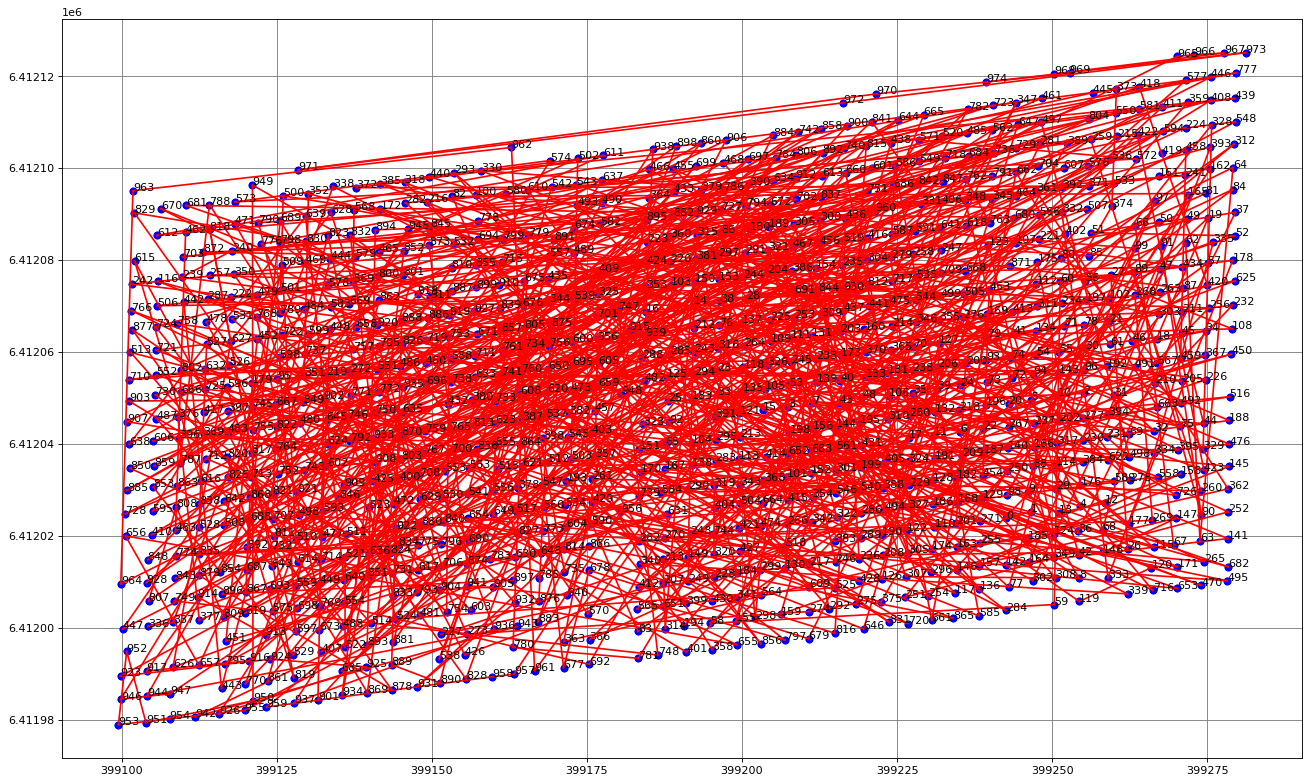

In [6]:
df = pd.read_csv("input/cimes_castillon1et2.csv")
coords = list(zip(df.x, df.y, df.z))
big_plot(coords)


In [68]:
pca = PCA(n_components=2)
pca.fit(points)

PCA(n_components=2)

Text(0, 0.5, 'Y')

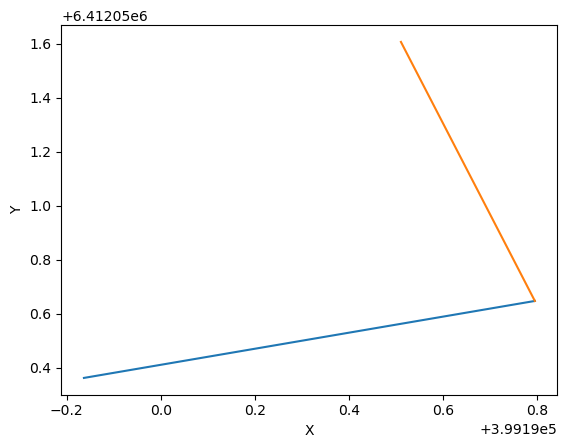

In [74]:
mean = pca.mean_
component = pca.components_

# Create the scatter plot
plt.figure()
for component in components:
    line_x = [mean[0], mean[0] + component[0]]
    line_y = [mean[1], mean[1] + component[1]]
    plt.plot(line_x, line_y)

plt.xlabel('X')
plt.ylabel('Y')

In [78]:
angle_x = math.degrees(
    math.atan2(pca.components_[0][1], pca.components_[0][0])
)
print(angle_x)
angle_y = math.degrees(
    math.atan2(pca.components_[1][1], pca.components_[1][0])
)
print(angle_y)

-163.4492428333982
106.54088494007716


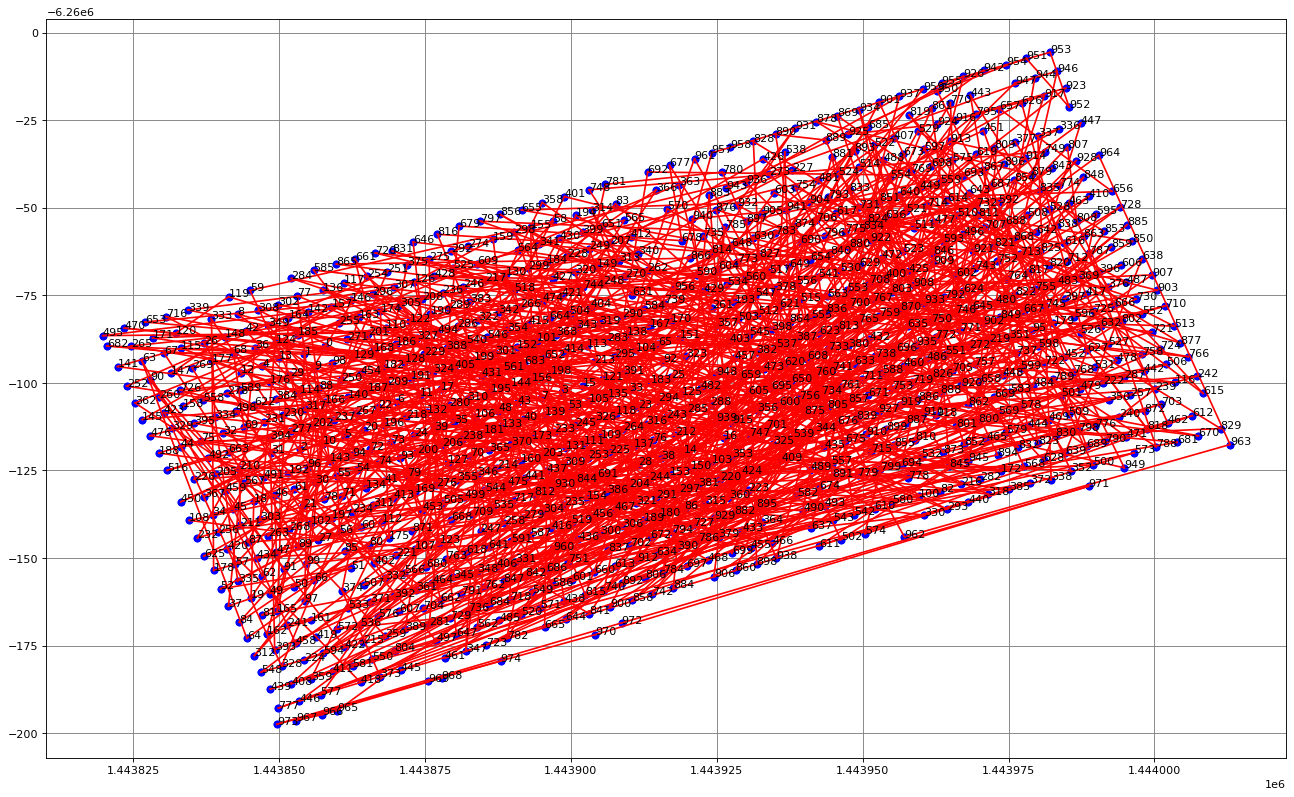

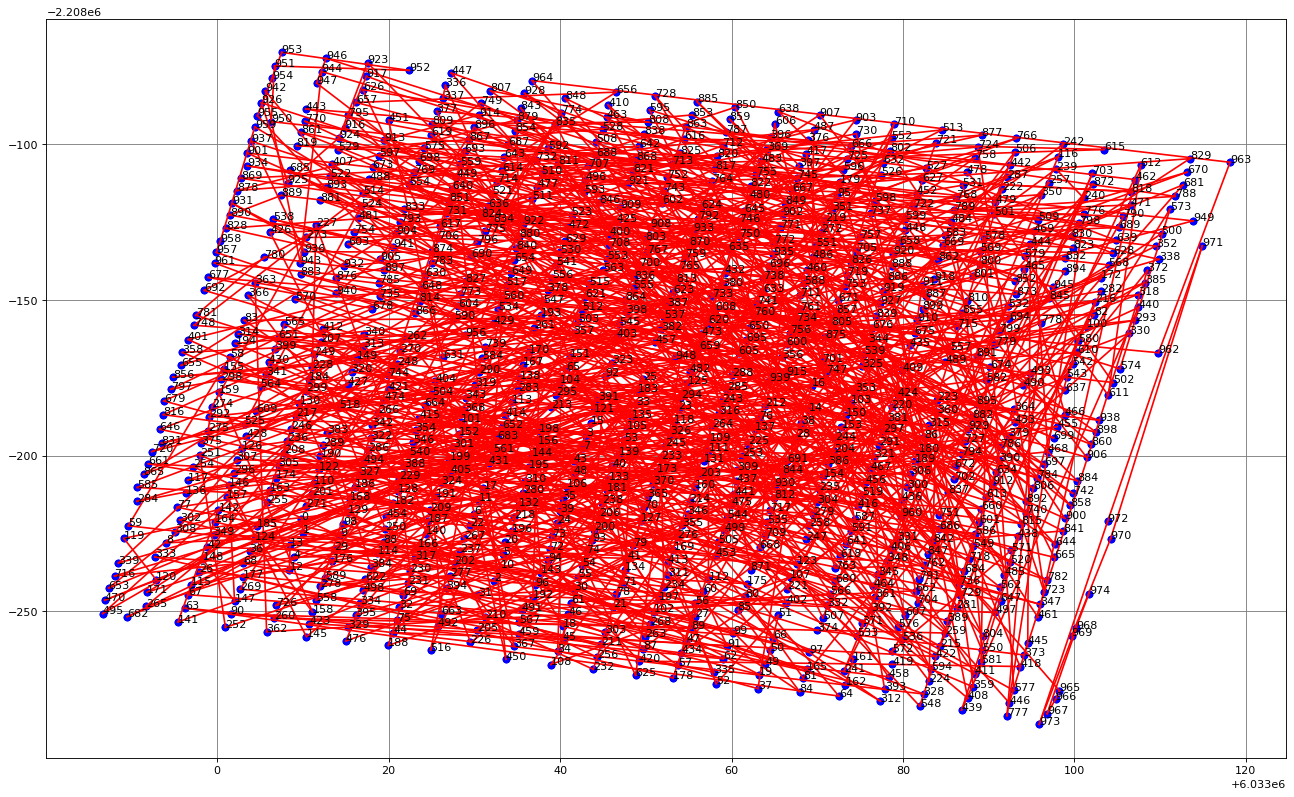

In [79]:
for a in [360+angle_x, 360-angle_y]:
    big_plot(csv2kml4path.get_rotated_coords(coords, angle=a))


In [81]:
angle_from_pca = get_angle_from_pca(coords)
angle_from_pca

(163.4492428333982, -106.54088494007716)

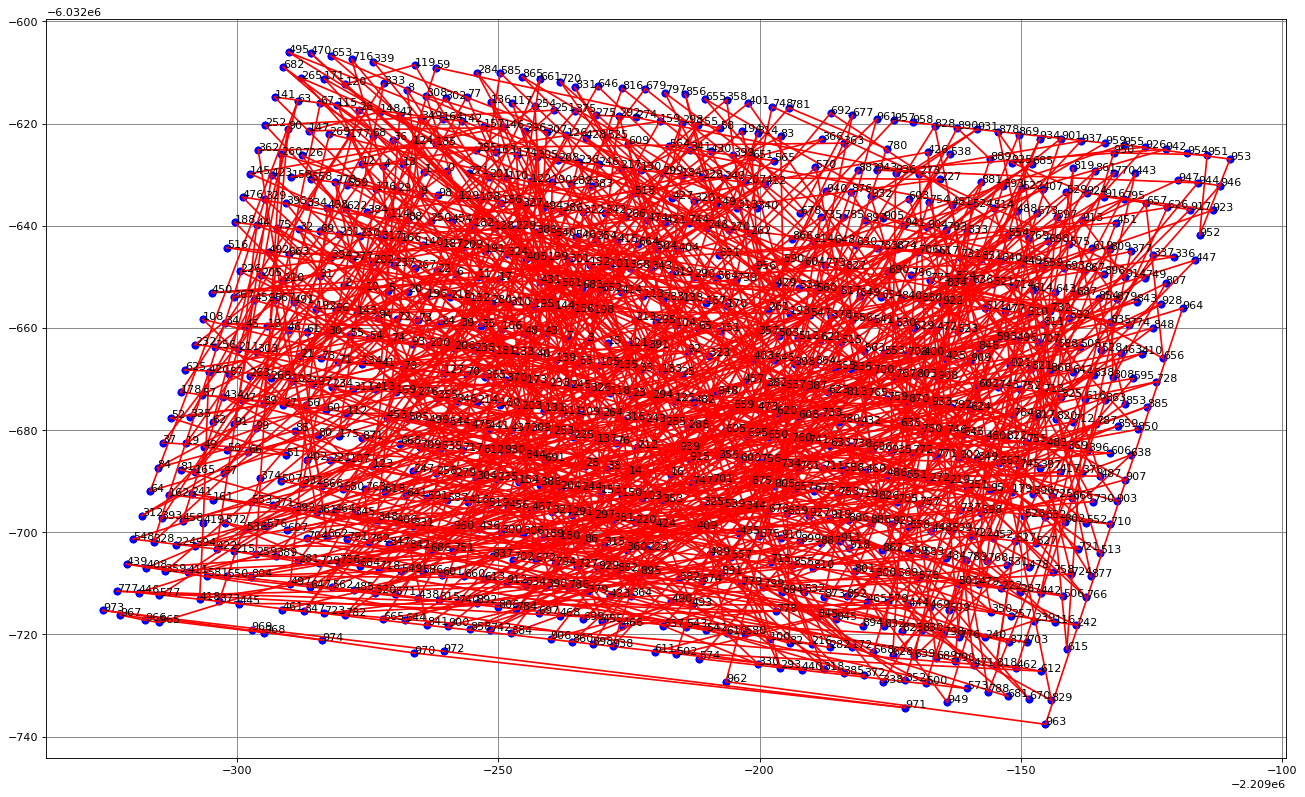

In [83]:
coords_r = csv2kml4path.get_rotated_coords(coords, angle=angle_from_pca[0]
                                          )
big_plot(coords_r)

### Methodes flip 

In [5]:
def flip_columns_1_out_of_2(
    coords: csv2kml4path.Coords,
    dist_min: float = 1.0,
    key = lambda c: c[0],
    flip: bool = True,
    axis: int = 1,
    show_plots = False
) -> csv2kml4path.Coords:
    """Specific sort for a boustrophedon path on coords."""
    sort_start_idx = 0
    for i in range(len(coords) - 1):
        dist_cur_and_next = csv2kml4path.dist(coords[i + 1], coords[i], axis=axis)
        if dist_cur_and_next > dist_min:
            # print(f"Pair of {i}-{i+1} : {dist_cur_and_next} is higher than {dist_min}")
            coords[sort_start_idx : i + 1] = sorted(
                coords[sort_start_idx : i + 1], key=key, reverse=flip
            )
            sort_start_idx = i + 1
            flip = not flip
    coords[sort_start_idx:] = sorted(
        coords[sort_start_idx:], key=key, reverse=flip
    )
    if show_plots:
        plot_dist_on_lines(coords, dist_min)
        plot_waypoints_with_numbers(coords)
    plt.show()
    return coords
    
def get_path_for_plot(df, outliers, threshold_z, sort_key, flip_key, dist_min, angle=None, do_flip=True, axis=1, debug=False):
    coords = list(zip(df.x, df.y, df.z))
    if debug:
        big_plot(coords)
        plt.show()
    csv2kml4path.clean_coordinates(
        coords=coords,
        outliers=outliers,
        zip_zh=zip(df.z, df.h),
        threshold_z=threshold_z,
    )
    if angle is None:
        angle = csv2kml4path.get_angle_from_pca(coords)
        if debug:
            print("angle from pca :", angle)
        angle = angle[0]
    coords_r = csv2kml4path.get_rotated_coords(coords, angle=angle)
    if debug:
        plt.figure(figsize=(24, 15), dpi=80)
        plot_waypoints_with_numbers(coords_r)
        plt.show()
    return csv2kml4path.retrieve_reorder_coords(
        coords=coords,
        coords_rotated=coords_r,
        coords_rotated_reordered=flip_columns_1_out_of_2(
            coords=sorted(coords_r, key=sort_key),
            dist_min=dist_min,
            key=flip_key,
            flip=do_flip,
            axis=axis,
            show_plots=debug
        )
    ) 

### Méthode make_path avec tolerance

In [4]:
def make_path(coords, tolerance = 1, nb_pts_min = 1, flip = True):
    final_path = []
    current_path = []
    for i in range(len(coords) - 1):
        current_path.append(coords[i])
        y1 = coords[i][1]
        y2 = coords[i + 1][1]
        if abs(y2 - y1) > tolerance:
            if len(current_path) > nb_pts_min:
                final_path += sorted(current_path, key=lambda c: c[0], reverse=flip)
                flip = not flip
            current_path = []
    return final_path

In [5]:
def debug_plot_range_angle(coords, angle_start, angle_end, angle_step=1):
    for a in range(angle_start, angle_end, angle_step):
        print("angle", a)
        big_plot_no_lines(csv2kml4path.get_rotated_coords(coords, angle=a))
        plt.show()

def debug_plot_range_tolerance(coords_rs, tol_start, tol_end, tol_step=0.1, nb_pts_min=1):
    for t in range(int(tol_start*10), int(tol_end*10), int(tol_step*10)):
        print("tolerance", t/10)
        big_plot(make_path(coords_rs, tolerance=t/10, nb_pts_min=nb_pts_min))
        plt.show()

def debug_plot_range_nb_pts_min(coords_rs, nb_pts_min_start, nb_pts_min_end, nb_pts_min_step=1, tolerance=1):
    for n in range(nb_pts_min_start, nb_pts_min_end, nb_pts_min_step):
        print("nb_pts_min", n)
        coords_rss = make_path(coords_rs, tolerance=tolerance, nb_pts_min=n)
        big_plot(coords_rss)
        print(len(coords_rss))
        plt.show()


### Liste des angles et dist min pour chaque parcelle

#### Castillon

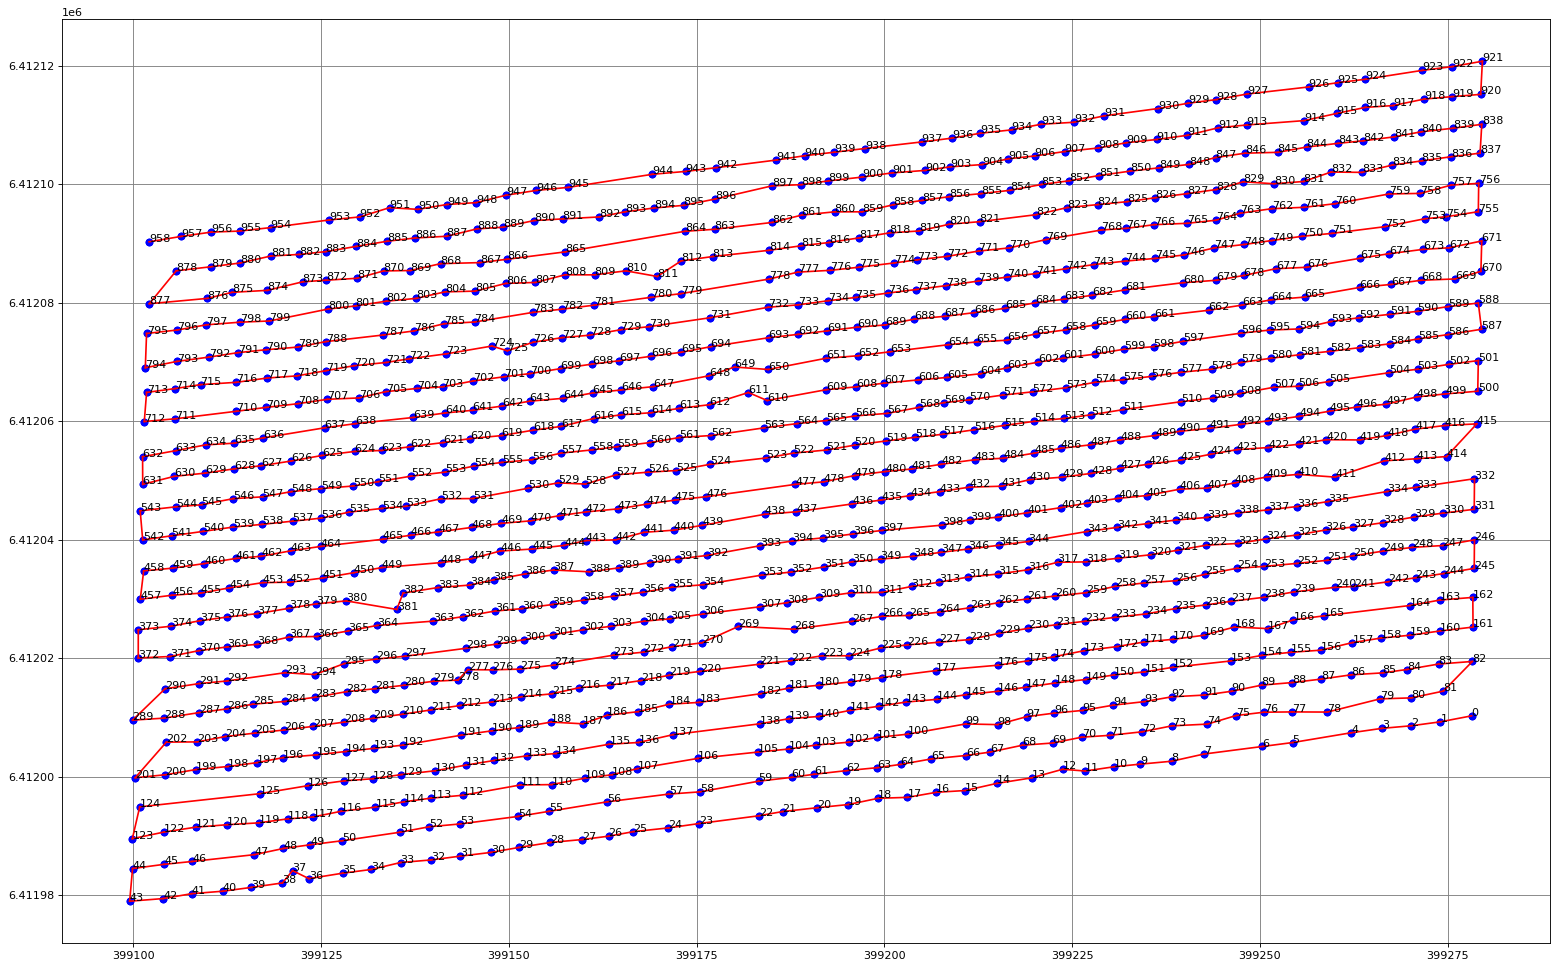

In [8]:
coords = get_coords_from_path("input/cimes_castillon1et2.csv")
coords_r = csv2kml4path.get_rotated_coords(coords, angle=-10)
coords_rs = sorted(coords_r, key=lambda c: c[1])
coords_rsf = make_path(coords_rs)
final_coords = csv2kml4path.retrieve_reorder_coords(coords,coords_r,coords_rsf)
big_plot(final_coords)

#### Matouneyres 2

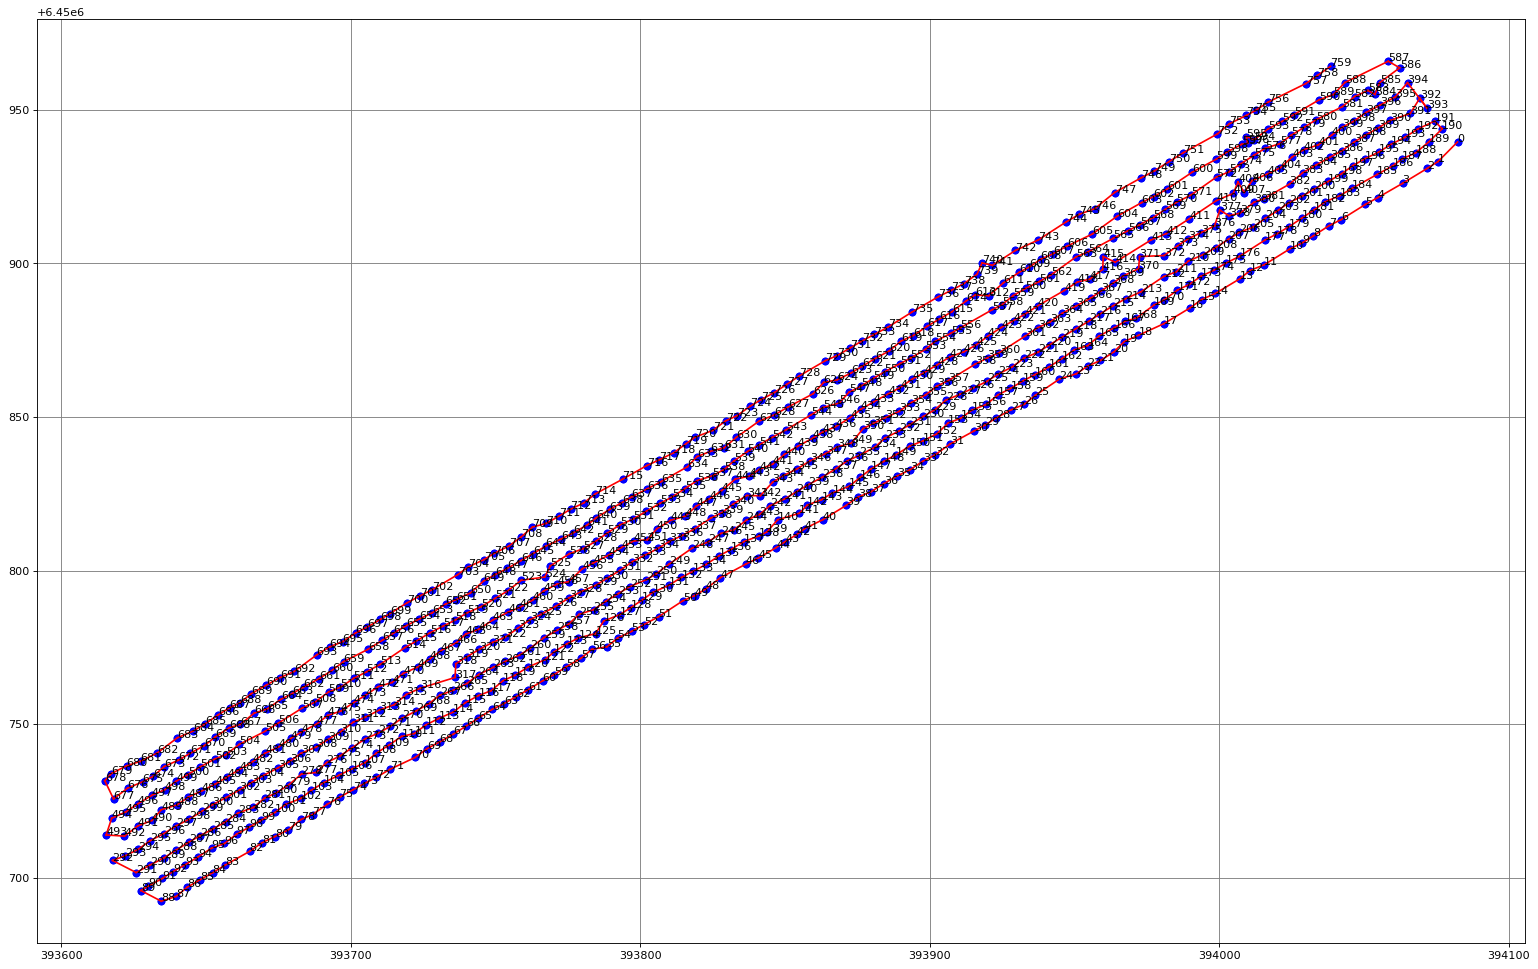

In [9]:
coords = get_coords_from_path("input/cimes_matouneyres2.csv")
coords_r = csv2kml4path.get_rotated_coords(coords, angle=-28.89)
coords_rs = sorted(coords_r, key=lambda c: c[1])
coords_rsf = make_path(coords_rs, tolerance=0.7, nb_pts_min=3)
final_coords = csv2kml4path.retrieve_reorder_coords(coords,coords_r,coords_rsf)
big_plot(final_coords)

#### Matouneyres 1

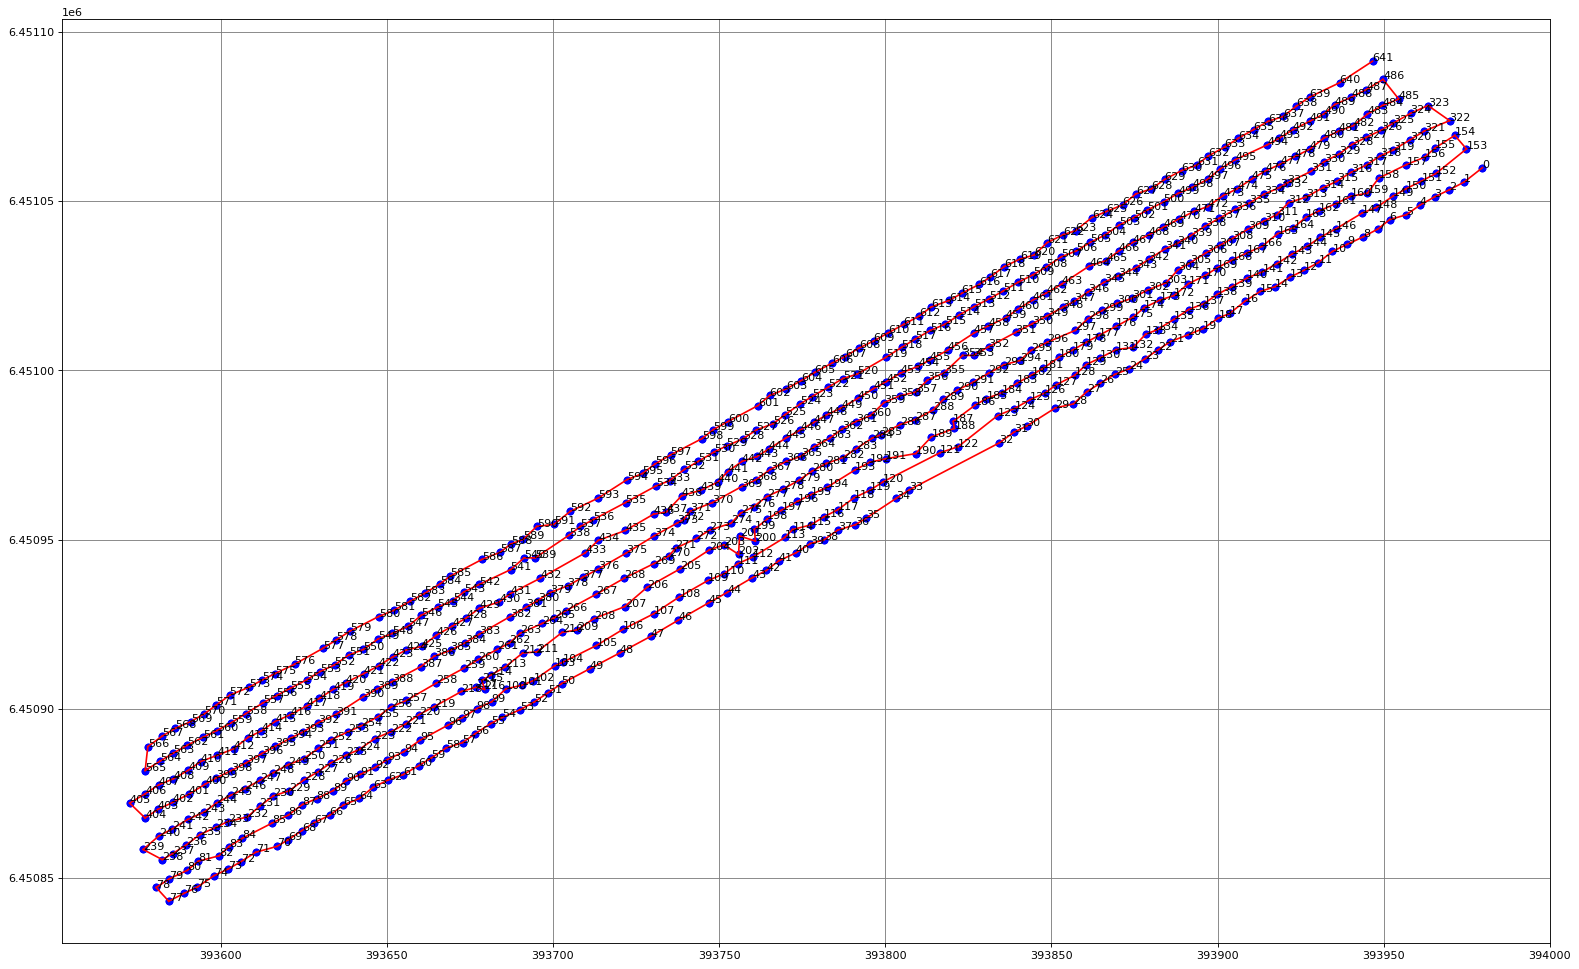

In [10]:
coords = get_coords_from_path("input/cimes_matouneyres1.csv")
coords_r = csv2kml4path.get_rotated_coords(coords, angle=-28.7)
coords_rs = sorted(coords_r, key=lambda c: c[1])
coords_rsf = make_path(coords_rs, tolerance=0.9, nb_pts_min=3)
final_coords = csv2kml4path.retrieve_reorder_coords(coords,coords_r,coords_rsf)
big_plot(final_coords)

#### Vacquey 1

Le =H= est au sud sur la gauche au niveau à peu près de 432520.

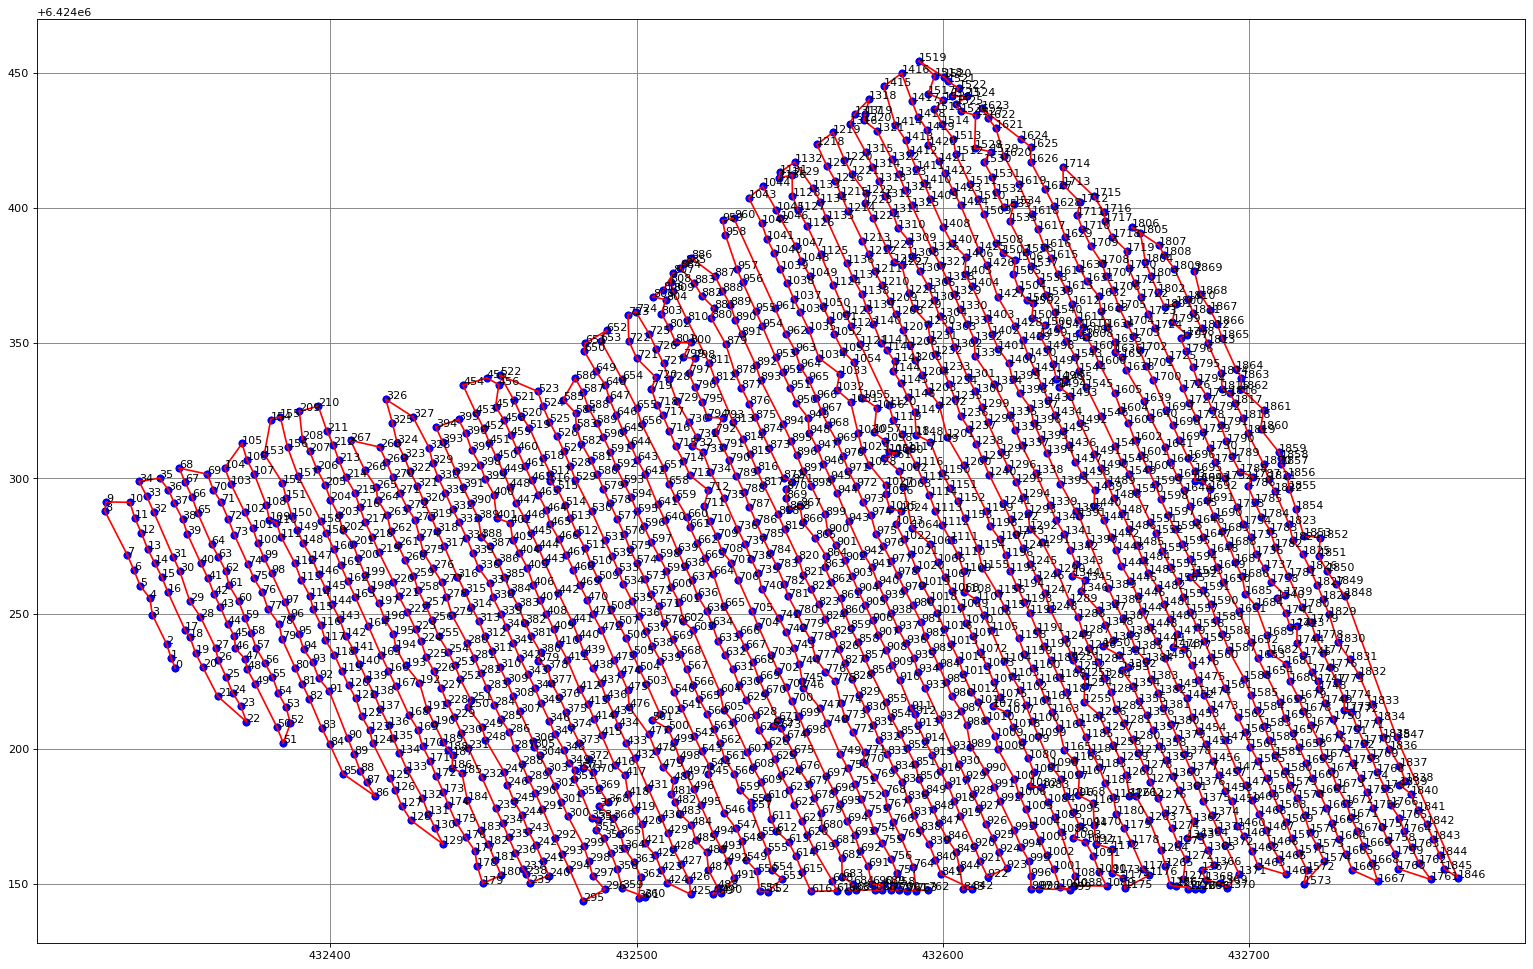

In [34]:
coords = get_coords_from_path("input/cimes_vaquey1.csv")
coords_r = csv2kml4path.get_rotated_coords(coords, angle=68.5)
coords_rs = sorted(coords_r, key=lambda c: c[1])
coords_rsf = make_path(coords_rs, tolerance=0.9, nb_pts_min=9)
final_coords = csv2kml4path.retrieve_reorder_coords(coords,coords_r,coords_rsf)
big_plot(final_coords)

#### Vacquey 2
Le =H= est au nord ouest

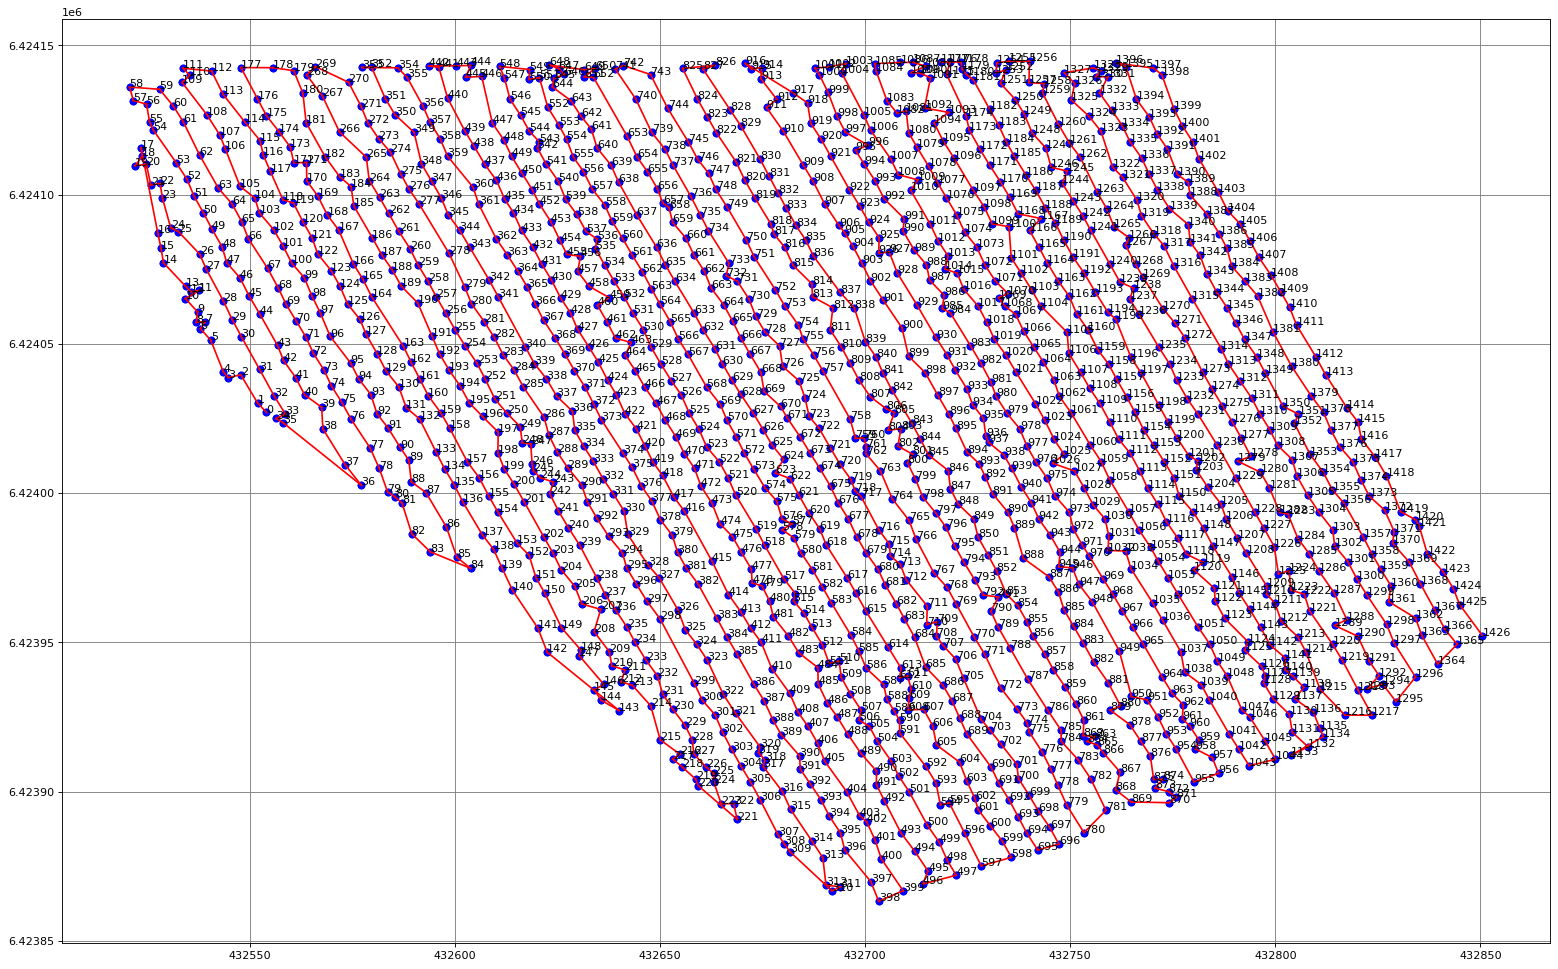

In [36]:
coords = get_coords_from_path("input/cimes_vaquey2.csv")
coords_r = csv2kml4path.get_rotated_coords(coords, angle=67.5)
coords_rs = sorted(coords_r, key=lambda c: c[1])
coords_rsf = make_path(coords_rs, tolerance=0.8, nb_pts_min=11)
final_coords = csv2kml4path.retrieve_reorder_coords(coords,coords_r,coords_rsf)
big_plot(final_coords)


#### Lanton

Le =H= est au nord est.

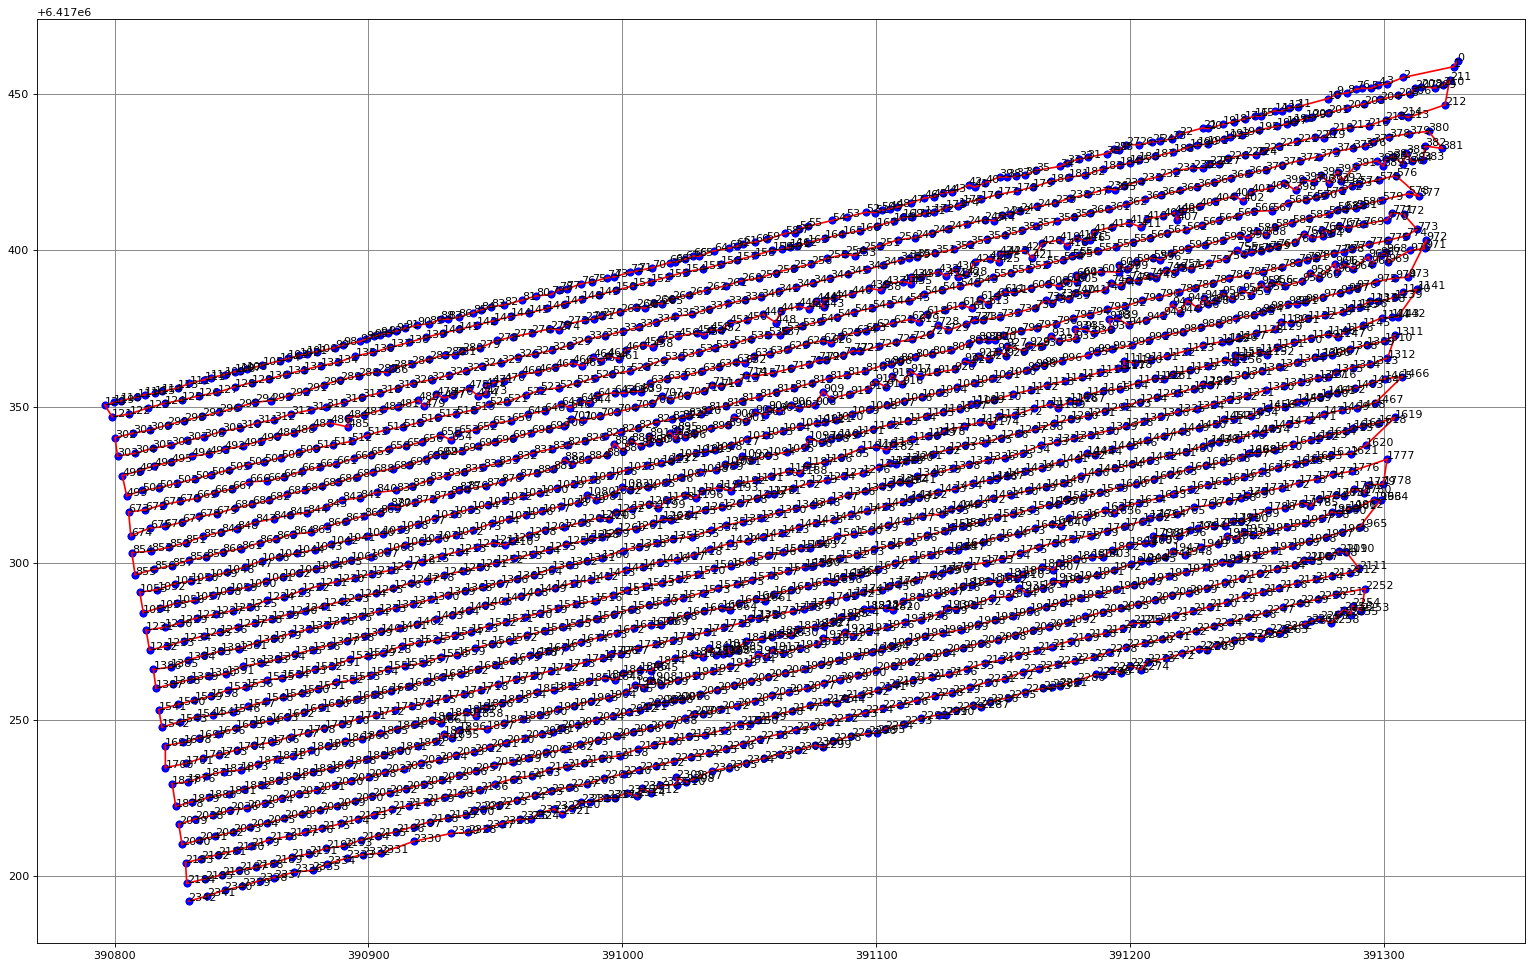

In [23]:
coords = get_coords_from_path("input/cimes_lanton.csv")
coords_r = csv2kml4path.get_rotated_coords(coords, angle=-11.5)
coords_rs = sorted(coords_r, key=lambda c: -c[1])
coords_rsf = make_path(coords_rs, tolerance=0.3, nb_pts_min=33)
final_coords = csv2kml4path.retrieve_reorder_coords(coords, coords_r, coords_rsf)
big_plot(final_coords)

#### Picard

Le =H= est au nord est ?

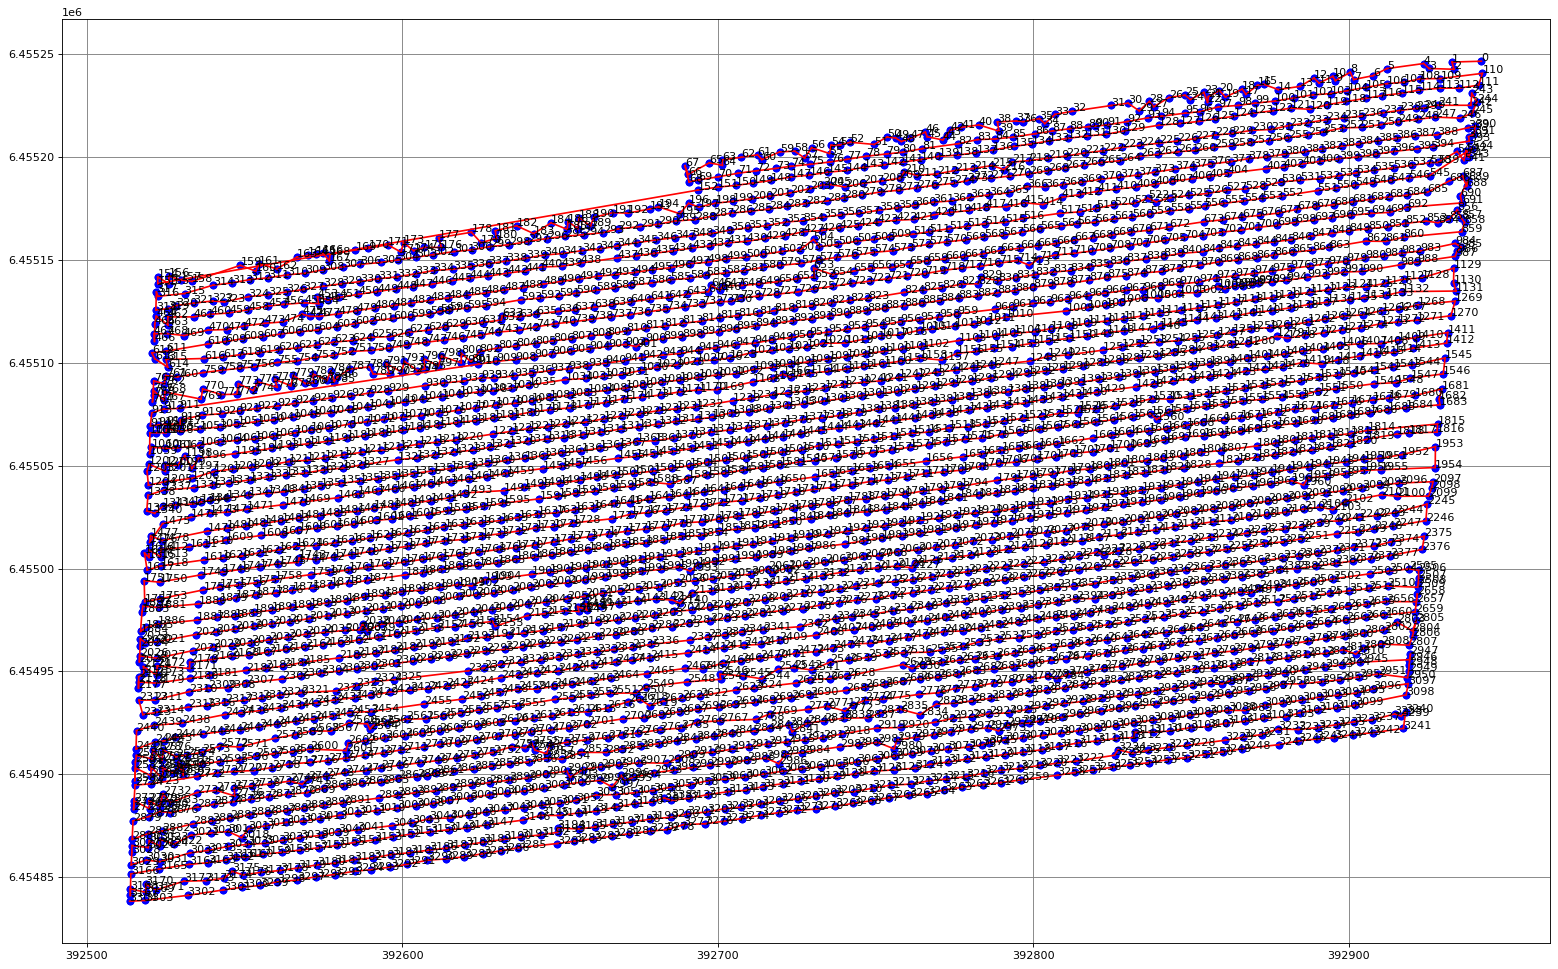

In [32]:
coords = get_coords_from_path("input/cimes_picard.csv")
coords_r = csv2kml4path.get_rotated_coords(coords, angle=-12)
coords_rs = sorted(coords_r, key=lambda c: -c[1])
coords_rsf = make_path(coords_rs, tolerance=0.8, nb_pts_min=7)
final_coords = csv2kml4path.retrieve_reorder_coords(coords, coords_r, coords_rsf)
big_plot(final_coords)

### Test artigues de lussac

In [8]:
def triple_points_at_highest(coords):
    triple_coords = []
    highest_z = max(coords, key=lambda c: c[2])[2]
    for i in range(0, len(coords)):
        triple_coords.extend([
            (coords[i][0], coords[i][1], highest_z),
            coords[i],
            (coords[i][0], coords[i][1], highest_z)]
        )
    return triple_coords
        

In [10]:
coords = get_coords_from_path("input/artigues_de_lussac.csv")
triple_coords = triple_points_at_highest(coords)
print(triple_coords)

[(-0.1413567000591043, 44.98369698972936, 25), (-0.1413567000591043, 44.98369698972936, 20), (-0.1413567000591043, 44.98369698972936, 25), (-0.1415490619436155, 44.98349909368131, 25), (-0.1415490619436155, 44.98349909368131, 15), (-0.1415490619436155, 44.98349909368131, 25), (-0.1413267340106117, 44.98339232402459, 25), (-0.1413267340106117, 44.98339232402459, 18), (-0.1413267340106117, 44.98339232402459, 25), (-0.1411240570816619, 44.98359195939523, 25), (-0.1411240570816619, 44.98359195939523, 25), (-0.1411240570816619, 44.98359195939523, 25)]


In [16]:
import simplekml 

class KmlCreator:
    def __init__(self, coords, kml_name: str, altitude_mode = simplekml.AltitudeMode.absolute) -> None:
        """Initializes the KmlCreator class.

        Args:
            coords (Coords): A list of tuples containing the converted WGS84 coordinates.
            kml_name (str): The name of the KML file to be created.
        """
        self.coords = coords
        self.kml_name = kml_name
        self.altitude_mode = altitude_mode

    def create_kml(self) -> None:
        """Create the Kml object and save it in a file named kml_name."""
        kml = simplekml.Kml()
        linestring = kml.newlinestring(name="Waypoints connected")
        linestring.coords = self.coords
        linestring.altitudemode = self.altitude_mode
        linestring.extrude = 1
        kml.save(self.kml_name)

        
kml_creator = KmlCreator(
    triple_coords, "output/artigues_de_lussac/artigues_de_lussac_triple_coordonnees.kml", simplekml.AltitudeMode.relativetoground
)
kml_creator.create_kml()